In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### balance cascade

In [2]:
def cascade_training(train_data, clf_config, classifier = 'LightGBM', num_iter = 10):
  
    good = train_data[train_data.GB == 0]
    bad = train_data[train_data.GB == 1]
    br = len(bad)/len(good)
    false_rate = br**(1/(num_iter - 1))
    
    keep_good = {}
    clf_threshold = []
    clf_cascade = {}
    for j, i in enumerate(range(num_iter)):
        keep_good[j] = good
        if j != (num_iter - 1):
            draw = random.sample(good.index.to_list(), len(bad))
            train_g = good.loc[draw]
            train_b = bad.copy()
            train_combine = pd.concat([train_g, train_b], axis = 0)
        elif j == (num_iter - 1):
            train_combine = pd.concat([good, bad], axis = 0)

        valid_g = good.copy()
        train_x, train_y, valid_x, valid_y = label_divide(train_combine, valid_g, 'GB', train_only = False)
        if classifier == 'LightGBM':
            clf = LGBMClassifier(**clf_config)
        elif classifier == 'RandomForest':
            clf = RandomForestClassifier(**clf_config)
        clf.fit(train_x, train_y)
        predict = clf.predict_proba(valid_x)[:, 1]
        predict_df = pd.DataFrame(dict(predict = predict), index = valid_x.index)
        predict_df = predict_df.sort_values(by = 'predict', ascending = False)
        keep_num = int(len(predict_df)*false_rate)
        keep_index = predict_df.index[:keep_num]
        threshold = predict_df.loc[keep_index[-1]].values[0]
        clf_threshold.append(threshold)
        clf_cascade[j] = clf

        if j != (num_iter - 1):
            good = good.loc[keep_index]
        
        return clf_cascade, clf_threshold, keep_good
    
    
def cascade_testing(test_data, clf_cascade, clf_threshold):
    
    if isinstance(clf_threshold, int):
        clf_threshold = [clf_threshold]*len(clf_cascade)
    
    test_x, test_y = label_divide(test_data, 'GB', train_only = True)
    predict_df = pd.DataFrame()
    for i in range(len(clf_cascade)):
        clf = clf_cascade[i]
        predict = clf.predict_proba(test_x)[:, 1]
        answer = (predict > clf_threshold[i]).astype(int)
        predict = pd.DataFrame({str(i): answer})
        predict_df = pd.concat([predict_df, predict], axis = 1)
    predict_y = (predict_df.apply(sum, axis = 1) == len(clf_cascade)).astype(int)
    result = pd.DataFrame(dict(predict = predict_y, truth = test_y))
    
    return result


def runall_cascade(train_set, test_data, config, classifier = 'LightGBM', num_iter = 10):
    
    num_set = len(train_set)
    table_set = pd.DataFrame()
    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        clf_cascade, clf_threshold, _ = cascade_training(train_set[f'set{i}'], config[f'set{i}'], classifier = classifier,
                                                        num_iter = num_iter)
        result = cascade_testing(test_data, clf_cascade, clf_threshold)
        table = cf_matrix(result, train_set[f'set{i}'].GB)
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
    
    return table_set

## 

### loading hyperparameters & datasets

In [44]:
### training data ###
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (4212, 88)  balance ratio: 5.0
Dimension of dataset 2 : (5814, 88)  balance ratio: 5.0
Dimension of dataset 3 : (4542, 88)  balance ratio: 5.0
Dimension of dataset 4 : (4134, 88)  balance ratio: 5.0
Dimension of dataset 5 : (4143, 88)  balance ratio: 4.98
Dimension of dataset 6 : (4405, 88)  balance ratio: 3.61
Dimension of dataset 7 : (4195, 88)  balance ratio: 4.63
Dimension of dataset 8 : (4140, 88)  balance ratio: 5.0
Dimension of dataset 9 : (1794, 88)  balance ratio: 25.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (6912, 97)  balance ratio: 5.0
Dimension of dataset 2 : (9354, 97)  balance ratio: 5.0
Dimension of dataset 3 : (7440, 97)  balance ratio: 5.0
Dimension of dataset 4 : (6774, 97)  balance ratio: 5.0
Dimension of dataset 5 : (6785, 97)  balance ratio: 4.98
Dimens

In [72]:
TPE_multi = True
base_learner = 'RandomForest'

iteration = 200 if base_learner == 'LightGBM' else 50
TPE = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
with open(f'hyperparameter/20211221/runhist_array_m2m4_m5_3criteria_{base_learner}C_{TPE}_{iteration}.data', 'rb') as f:
    best_paramC = pickle.load(f)

### classifier


 Dataset 0:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0323542107751444

 Dataset 1:
Precision: 0.0010448856183722015 
Recall: 0.9215686274509803 
Aging Rate: 0.9246027667577956

 Dataset 2:
Precision: 0.0010501260151218146 
Recall: 0.8823529411764706 
Aging Rate: 0.8808403050422413

 Dataset 3:
Precision: 0.0010507560875325506 
Recall: 0.9019607843137255 
Aging Rate: 0.899874612016691

 Dataset 4:
Precision: 0.0011105693699550354 
Recall: 0.803921568627451 
Aging Rate: 0.758864519311805

 Dataset 5:
Precision: 0.0010419668787549604 
Recall: 0.9215686274509803 
Aging Rate: 0.9271927480523752

 Dataset 6:
Precision: 0.0010365827322593184 
Recall: 0.9411764705882353 
Aging Rate: 0.9518386811650805

 Dataset 7:
Precision: 0.0010629155547514587 
Recall: 0.9215686274509803 
Aging Rate: 0.9089189911406196

 Dataset 8:
Precision: 0.0010983104713387704 
Recall: 0.9215686274509803 
Aging Rate: 0.879627536023351

 Dataset 9:
Precision: 0.0011167638664846755 
Recall: 0.7058823529411765 
Aging Ra

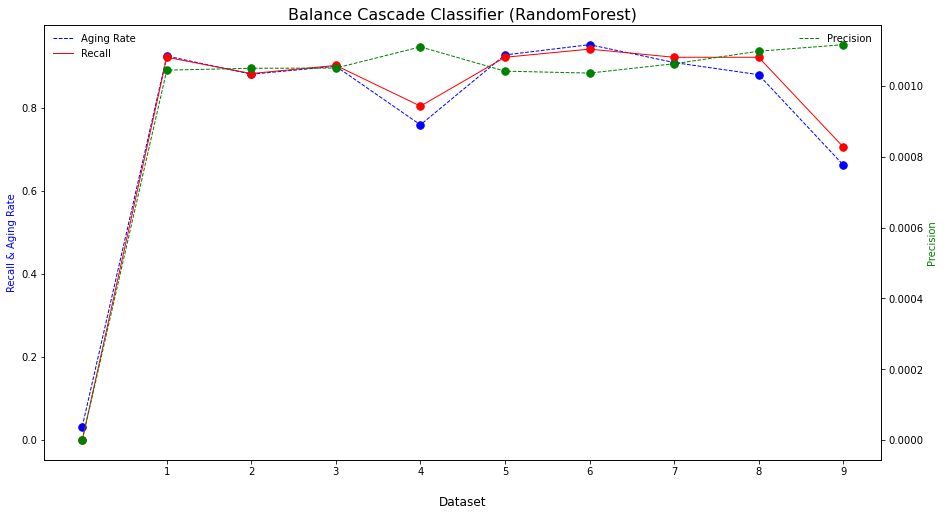

In [73]:
table_setC = runall_cascade(run_train, run_test, best_paramC, classifier = base_learner, num_iter = 3)
line_chart(table_setC, title = f'Balance Cascade Classifier ({base_learner})')

In [50]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,515.934211,156844.0,304.0,0.0,109.0,51.0,48489.0,0.000000,0.000000,0.002241,0.000000,0.000000
dataset 1,5.000000,15335.0,3067.0,32.0,24623.0,19.0,23975.0,0.001298,0.627451,0.506794,1.238080,0.505486
dataset 2,5.000000,21020.0,4204.0,27.0,22527.0,24.0,26071.0,0.001197,0.529412,0.463607,1.141942,0.403260
dataset 3,5.000000,16680.0,3336.0,31.0,26653.0,20.0,21945.0,0.001162,0.607843,0.548500,1.108191,0.453348
dataset 4,5.000000,15190.0,3038.0,33.0,24432.0,18.0,24166.0,0.001349,0.647059,0.502888,1.286686,0.535185
dataset 5,4.936668,15200.0,3079.0,35.0,28221.0,16.0,20377.0,0.001239,0.686275,0.580814,1.181574,0.535326
dataset 6,3.583215,15200.0,4242.0,33.0,28601.0,18.0,19997.0,0.001152,0.647059,0.588584,1.099349,0.479877
dataset 7,4.631322,15200.0,3282.0,33.0,29776.0,18.0,18822.0,0.001107,0.647059,0.612736,1.056015,0.466381
dataset 8,5.000000,15200.0,3040.0,31.0,26099.0,20.0,22499.0,0.001186,0.607843,0.537113,1.131686,0.460085
dataset 9,25.000000,7600.0,304.0,17.0,11076.0,34.0,37522.0,0.001532,0.333333,0.228021,1.461853,0.300305


### export

In [74]:
savedate = '20220111'

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'BalanceCascade_rf_iter3_br5'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'BalanceCascade_rf_iter3_br5')